Topic:        Challenge Set 1
Subject:      Explore MTA turnstile data
Date:         xx/xx/xxxx
Name:         student name
Worked with:  other students' name
Location:     nyc17_ds10/student_submissions/challenges/01-mta/shaikh_reshama/challenge_set_1_reshama.ipynb

In [3]:
import sys
print("Python Version:", sys.version)

Python Version: 3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Challenge 1

In [4]:
import pandas as pd
import datetime

In [5]:
def clean_data(df):
    
    df.columns = ['C/A','UNIT','SCP','STATION','LINENAME',\
              'DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
    
    df['converted_time'] = pd.to_datetime(df['DATE']+' '+df['TIME'])
    df['turnstiles'] = df['C/A'] + '-' + df['UNIT'] + '-' + df['SCP'] + '-' + df['STATION']
    
    df_sorted = df.sort_values(['turnstiles', 'converted_time'])
    
    turnstile_df = df_sorted.groupby('turnstiles')
    df_sorted['entries_diff'] = turnstile_df['ENTRIES'].diff()
    df_sorted['exits_diff'] = turnstile_df['EXITS'].diff()
    
    df_sorted['entries_diff'] = df_sorted['entries_diff'].fillna(0)
    df_sorted['exits_diff'] = df_sorted['exits_diff'].fillna(0)
    df_sorted['total_turns'] = df_sorted['entries_diff'] + df_sorted['exits_diff']
    df_sorted['station_unique'] = df_sorted['STATION'] + '-' + df_sorted['LINENAME']
    df_sorted['day_of_week']= df_sorted.converted_time.dt.dayofweek
    
    
    return df_sorted

In [6]:
def remove_outliers(df_sorted):
    # calculates IQR for entries_diff
    Q3 = df_sorted['entries_diff'].quantile(0.75) 
    Q1 = df_sorted['entries_diff'].quantile(0.25)
    IQR = Q3 - Q1
    # calculates IQR range using outliers 
    IQR_range = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    IQR_range
    # removes values outside of lower and upper bounds
    df_sorted = df_sorted[df_sorted['entries_diff'].between(IQR_range[0], IQR_range[1])]
    # repeats process for exits_diff
    Q3_2 = df_sorted['exits_diff'].quantile(0.75) 
    Q1_2 = df_sorted['exits_diff'].quantile(0.25)
    IQR_2 = Q3_2 - Q1_2
    IQR_range_2 = (Q1_2 - 1.5 * IQR, Q3_2 + 1.5 * IQR)
    IQR_range_2
    df_sorted = df_sorted[df_sorted['exits_diff'].between(IQR_range_2[0], IQR_range_2[1])]
    return df_sorted

In [15]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190803.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190810.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190817.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190824.txt')
df5 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190831.txt')
df_sorted = remove_outliers(clean_data(df1))
df2_sorted = remove_outliers(clean_data(df2))
df3_sorted = remove_outliers(clean_data(df3))
df4_sorted = remove_outliers(clean_data(df4))
df5_sorted = remove_outliers(clean_data(df5))

In [17]:
df_list = [df_sorted,df2_sorted,df3_sorted,df4_sorted,df5_sorted]
df_sorted_concat = pd.concat(df_list)
df_sorted_concat['weekly_turns'] = df_sorted_concat['total_turns']/len(df_list)

Text(0.5, 0.98, 'Daily Entries For Turnstile A002-R051-02-00-01-59 ST')

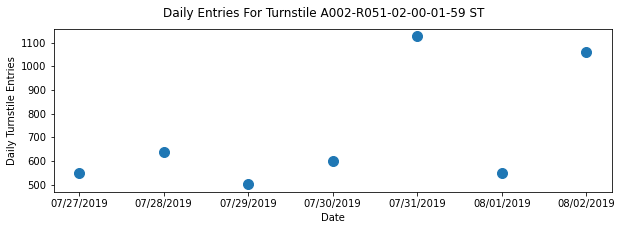

In [18]:
#Challenge 4 Code

%matplotlib inline
import matplotlib.pyplot as plt

#Filter DF for data of just 1 turnstile, sort by date
single_turnstile = df_sorted[df_sorted.turnstiles == 'A002-R051-02-00-01-59 ST']
single_turnstile_sorted = single_turnstile.groupby('DATE').sum()

#Plot daily entries for 1 turnstile
plt.figure(figsize=(10,3))
x = single_turnstile_sorted.index
y = single_turnstile_sorted['entries_diff']
plt.scatter(x, y, s=100)
plt.xlabel('Date')
plt.ylabel('Daily Turnstile Entries')
plt.suptitle('Daily Entries For Turnstile A002-R051-02-00-01-59 ST'  )

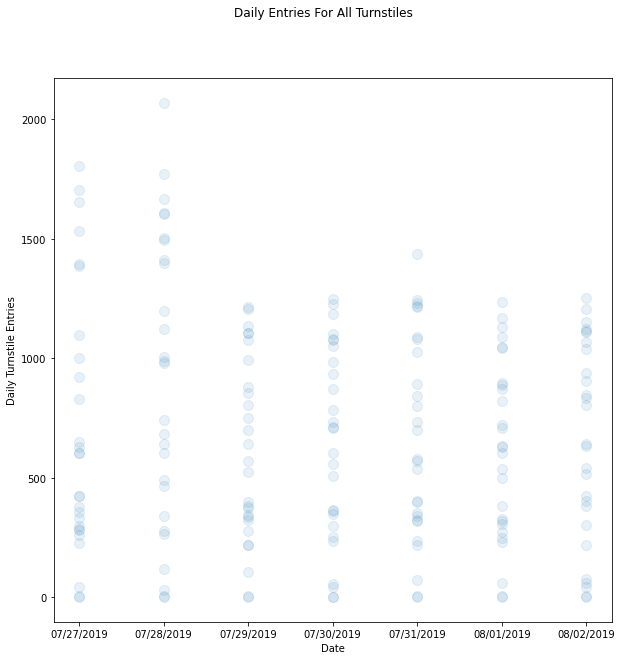

In [19]:
def plot_daily_turnstile_entries(df_sorted, station=None): 
    if isinstance(station, str) != True and station !=None:
        raise TypeError('Station should be a string')
    if station != None:
        df_sorted = df_sorted[df_sorted.STATION == station]

    
    df_sorted_turnstiles_date = df_sorted.groupby(['turnstiles', 'DATE']).sum()
    df_sorted_turnstiles = df_sorted_turnstiles_date.reset_index(level=['DATE'])
    plt.figure(figsize=(10,10))
    x = df_sorted_turnstiles.DATE
    y = df_sorted_turnstiles.entries_diff
    plt.scatter(x,y,s=100,alpha=0.1)
    plt.xlabel('Date')
    plt.ylabel('Daily Turnstile Entries')
    plt.suptitle('Daily Entries For All Turnstiles')

plot_daily_turnstile_entries(df_sorted, station='FLUSHING-MAIN')

#Alternate code using "unique station" column with station/line name combo
def plot_daily_turnstile_entries_unique(df_sorted, station=None): 
    if isinstance(station, str) != True and station !=None:
        raise TypeError('Station should be a string')
    if station != None:
        df_sorted = df_sorted[df_sorted.station_unique == station]

    
    df_sorted_turnstiles_date = df_sorted.groupby(['turnstiles', 'DATE']).sum()
    df_sorted_turnstiles = df_sorted_turnstiles_date.reset_index(level=['DATE'])
    plt.figure(figsize=(10,10))
    x = df_sorted_turnstiles.DATE
    y = df_sorted_turnstiles.entries_diff
    plt.scatter(x,y,s=100,alpha=0.1)
    plt.xlabel('Date')
    plt.ylabel('Daily Turnstile Entries')
    plt.suptitle('Daily Entries For All Turnstiles')

### Code for plotting total turnstile turns for all stations (Can also plot just entries, just exits, or "entry ratio" by changing metric argument

<IPython.core.display.Javascript object>


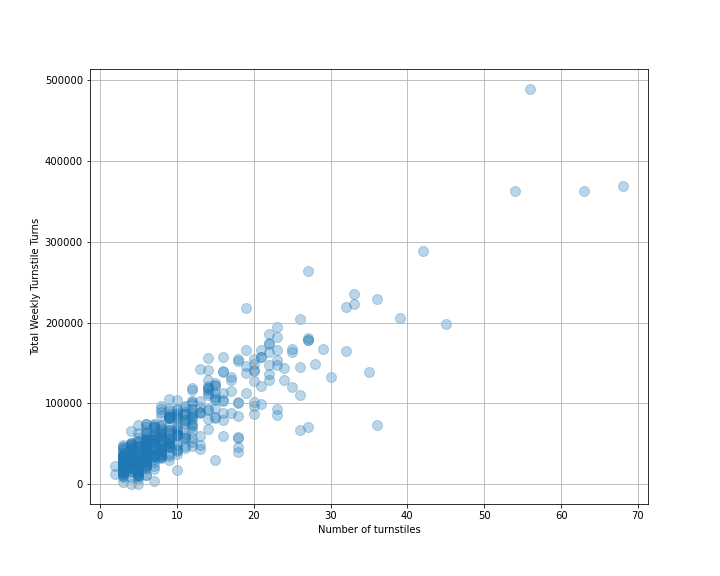

In [24]:
def plot_total_traffic_by_station(df_sorted, metric='total_turns'):
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    #Group by Station-Line Name Combo... eg, 34th Penn Station is one huge station but the street team
    #cannot be at the A-C-E entrance and the 1-2-3 entrance simultaneously, so that traffic should be 
    #split accordingly
    df_sorted_station = df_sorted.groupby(['station_unique', 'turnstiles']).agg({'entries_diff': 'sum', 'exits_diff':'sum',\
                                  'total_turns':'sum', 'weekly_turns':'sum'})
    #Reset turnstiles index and aggregate again to count number of turnstiles per station
    #Add turns per turnstile column
    df_sorted_station = df_sorted_station.reset_index(level='turnstiles').groupby('station_unique').agg({'turnstiles':'count', 'entries_diff': 'sum', 'exits_diff':'sum',\
                                  'total_turns':'sum', 'weekly_turns':'sum'})
    df_sorted_station['weekly_turns_per_turnstile'] = df_sorted_station['weekly_turns']/df_sorted_station['turnstiles']
    df_sorted_station['entry_ratio'] = df_sorted_station['entries_diff']/df_sorted_station['total_turns']
    
    #Set y values to be total entries + exits,  x values to be # of turnstiles at each station
    #names will be the station name labels for each scatter plot point
    x = df_sorted_station.turnstiles
    y = df_sorted_station[metric]
    names = df_sorted_station.index

    #initiate scatter plot
    %matplotlib notebook
    fig,ax = plt.subplots(figsize=(10,8))
    sc = ax.scatter(x,y,s=100, alpha=0.3)

    annot = ax.annotate("", xy=(0,0), xytext=(-30,-30), size = 15, textcoords="offset points", \
                    bbox=dict(boxstyle="round", fc="w"), arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):
        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}".format(" ".join([names[n] for n in ind["ind"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)
    
    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
                
    fig.canvas.mpl_connect("motion_notify_event", hover)

    ax.set_xlabel('Number of turnstiles')
    ax.set_ylabel('Total Weekly Turnstile Turns')
    ax.grid(True)
    plt.show()
    
    
    
plot_total_traffic_by_station(df_sorted, metric='total_turns')



### Code for plotting traffic density (turns per turnstile) of x amount of busiest stations (change amt to be displayed by changing stations argument)

<IPython.core.display.Javascript object>


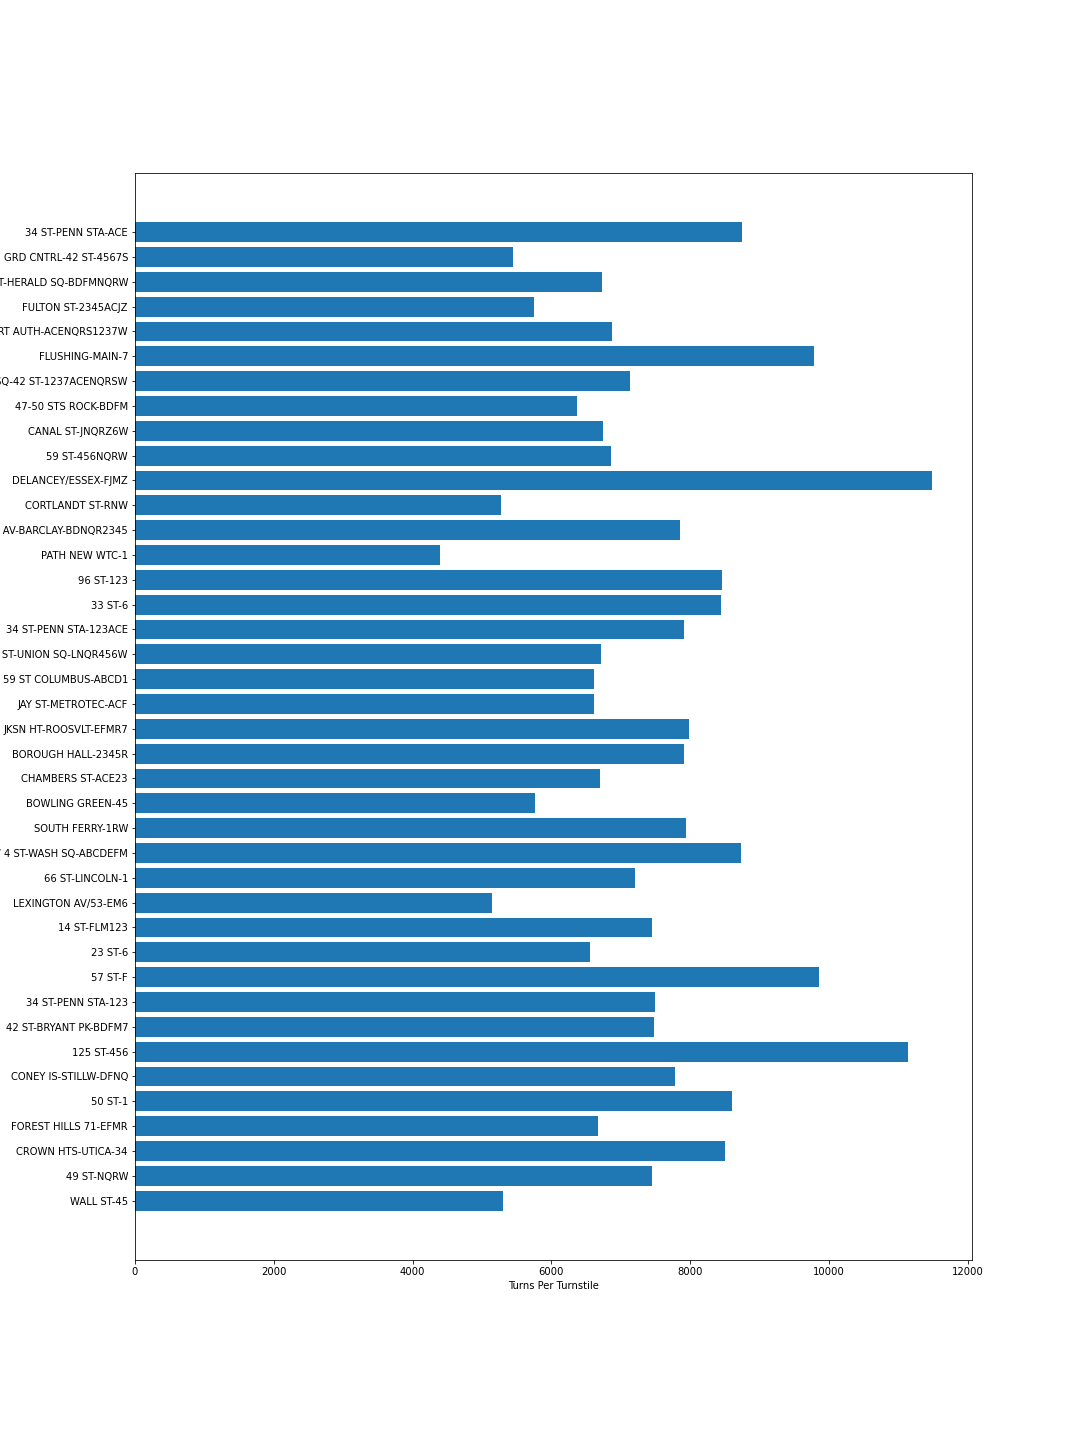

In [25]:
def plot_traffic_density(df_sorted, stations = 10):
    import numpy as np
    import matplotlib.pyplot as plt
    
    #Group by Station-Line Name Combo... eg, 34th Penn Station is one huge station but the street team
    #cannot be at the A-C-E entrance and the 1-2-3 entrance simultaneously, so that traffic should be 
    #split accordingly
    df_sorted_station = df_sorted.groupby(['station_unique', 'turnstiles']).agg({'entries_diff': 'sum', 'exits_diff':'sum',\
                                  'total_turns':'sum'})
    #Reset turnstiles index and aggregate again to count number of turnstiles per station
    #Add turns per turnstile column
    df_sorted_station = df_sorted_station.reset_index(level='turnstiles').groupby('station_unique').agg({'turnstiles':'count', 'entries_diff': 'sum', 'exits_diff':'sum',\
                                  'total_turns':'sum'})
    df_sorted_station['turns_per_turnstile'] = df_sorted_station['total_turns']/df_sorted_station['turnstiles']
    
    #Set y values to be total entries + exits,  x values to be # of turnstiles at each station
    #names will be the station name labels for each scatter plot point
    x = df_sorted_station.turnstiles
    y = df_sorted_station.total_turns

#Plot bar graph of the traffic density, or turns per turnstile, for busiest subway stations
    df_busiest = df_sorted_station.sort_values('total_turns', ascending=False).head(stations)
    fig,ax = plt.subplots(figsize=(15,stations/2))
    y_pos = np.arange(len(df_busiest.turns_per_turnstile))
    ax.barh(y_pos, df_busiest.turns_per_turnstile)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_busiest.index)
    ax.set_xlabel('Turns Per Turnstile')
    ax.invert_yaxis() #set labels so that busiest stations are at top

plot_traffic_density(df_sorted, stations = 40)

In [26]:
def plot_traffic_by_day_of_week(df_sorted_concat, num_stations=10, custom_stations=None):
    df_sorted_station = df_sorted.groupby(['station_unique', 'turnstiles', 'day_of_week'\
                                              ]).agg({'entries_diff': 'sum', 'exits_diff':'sum',\
                                                  'total_turns':'sum'})

    df_sorted_station = df_sorted_station.reset_index(level='turnstiles').groupby(['station_unique', \
                                                    'day_of_week']).agg({'entries_diff': \
                                                        'sum', 'exits_diff':'sum',\
                                                          'total_turns':'sum'})

    df_sorted_station = df_sorted_station.reset_index(level=['station_unique', 'day_of_week'])

    df_busiest = df_sorted_station.groupby('station_unique').sum().sort_values('total_turns',\
                                                                            ascending = False)
    
    
    busiest_stations = df_busiest.index
    
    plt.figure(figsize=(14,10))
    
    if custom_stations != None:
        for station in custom_stations:
            df_subset = df_sorted_station[df_sorted_station.station_unique == station]
            daily_mean = (df_subset.total_turns.sum())/df_subset.total_turns.count()
            df_subset['deviation_from_daily_mean'] = (df_subset['total_turns']-daily_mean)/daily_mean
            plt.plot('day_of_week', 'total_turns', data=df_subset, label=station)
    else:
        for station in busiest_stations[:num_stations]:
            df_subset = df_sorted_station[df_sorted_station.station_unique == station]
            daily_mean = (df_subset.total_turns.sum())/df_subset.total_turns.count()
            df_subset['deviation_from_daily_mean'] = (df_subset['total_turns']-daily_mean)/daily_mean
            plt.plot('day_of_week', 'deviation_from_daily_mean', data=df_subset, label=station)
    plt.legend(framealpha=0.25, fontsize='small', bbox_to_anchor=(1.05,1))
    plt.tight_layout()

<IPython.core.display.Javascript object>


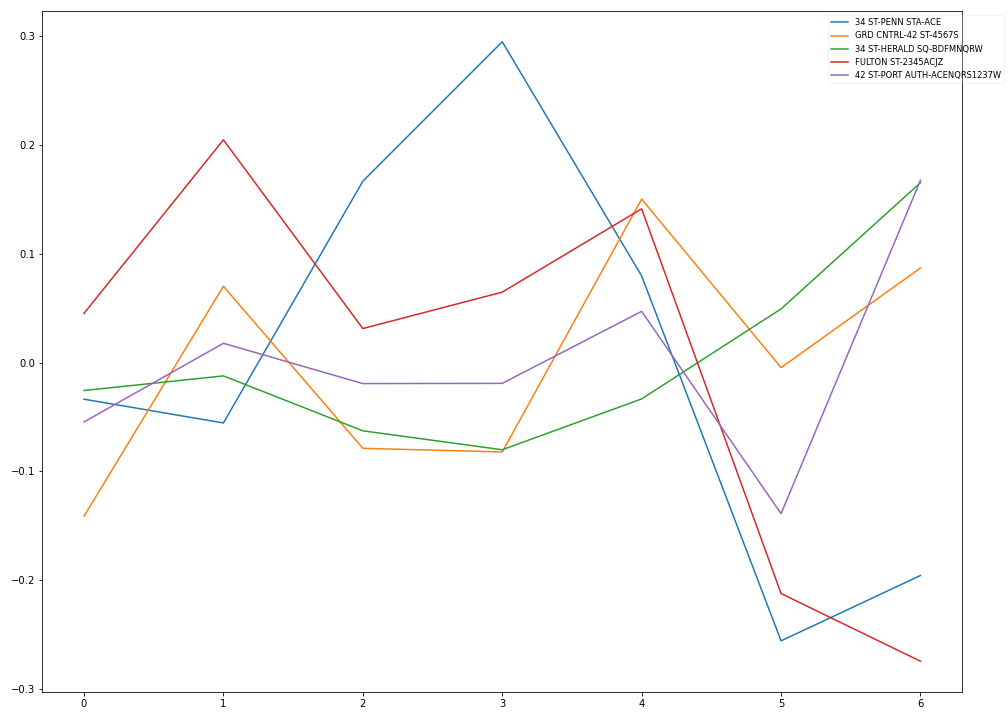

/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [28]:
plot_traffic_by_day_of_week(df_sorted_concat,num_stations=5)

In [150]:
# station_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
# df_sorted.sample(10)
# df_sorted[df_sorted['STATION'].str.contains('42 ST')].sample(10)
# station_df.sample(10)

In [108]:
df_sorted

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,converted_time,turnstiles,entries_diff,exits_diff,total_turns,station_unique,day_of_week
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,00:00:00,REGULAR,7148288,2418935,2019-07-27 00:00:00,A002-R051-02-00-00-59 ST,0.0,0.0,0.0,59 ST-NQR456W,5
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,04:00:00,REGULAR,7148306,2418939,2019-07-27 04:00:00,A002-R051-02-00-00-59 ST,18.0,4.0,22.0,59 ST-NQR456W,5
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,08:00:00,REGULAR,7148326,2418975,2019-07-27 08:00:00,A002-R051-02-00-00-59 ST,20.0,36.0,56.0,59 ST-NQR456W,5
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,12:00:00,REGULAR,7148441,2419042,2019-07-27 12:00:00,A002-R051-02-00-00-59 ST,115.0,67.0,182.0,59 ST-NQR456W,5
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,16:00:00,REGULAR,7148647,2419101,2019-07-27 16:00:00,A002-R051-02-00-00-59 ST,206.0,59.0,265.0,59 ST-NQR456W,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205258,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/30/2019,05:00:00,REGULAR,5554,389,2019-08-30 05:00:00,TRAM2-R469-00-05-01-RIT-ROOSEVELT,0.0,0.0,0.0,RIT-ROOSEVELT-R,4
205259,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/30/2019,09:00:00,REGULAR,5554,389,2019-08-30 09:00:00,TRAM2-R469-00-05-01-RIT-ROOSEVELT,0.0,0.0,0.0,RIT-ROOSEVELT-R,4
205260,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/30/2019,13:00:00,REGULAR,5554,389,2019-08-30 13:00:00,TRAM2-R469-00-05-01-RIT-ROOSEVELT,0.0,0.0,0.0,RIT-ROOSEVELT-R,4
205261,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/30/2019,17:00:00,REGULAR,5554,389,2019-08-30 17:00:00,TRAM2-R469-00-05-01-RIT-ROOSEVELT,0.0,0.0,0.0,RIT-ROOSEVELT-R,4
